## Introduction

I completed this project as part of my Advanced Data Science Methods course that I took at the University of Washington.

This Jupyter Notebook uses data from the [Progresa
program](http://en.wikipedia.org/wiki/Oportunidades), a government
social assistance program in Mexico. This program, as well as the
details of its impact, are described in the paper "[School subsidies
for the poor: evaluating the Mexican Progresa poverty
program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)",
by Paul Shultz.

The goal of this Notebook is to implement some of the basic
econometric techniques that might be used to evaluate a program like Progresa.

Say we want to measure the impact of Progresa on secondary school enrollment rates, in particular differences-in-differences.  We can try to estimate the impact of
_progresa_ subsidies on the school attendance, which is to say establishing a cause-effect relationship.

The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages given access to the program. 
 
In the data, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are
surveyed in both years.  For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey (=1)|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = "pobre", not poor = "no pobre"|
|progresa |program = "basal", control = "0"|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|enrolled in school in 1997 (=1) |

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## EDA

In [2]:
data = pd.read_csv('progresa_sample.csv.gz', delimiter=',')
print(data.head(5))

   year  sex  indig  dist_sec   sc  grc  fam_n   min_dist   dist_cap   poor  \
0    97  0.0    0.0     4.473  1.0  7.0      7  21.168384  21.168384  pobre   
1    98  0.0    0.0     4.473  1.0  8.0      7  21.168384  21.168384  pobre   
2    97  1.0    0.0     4.473  1.0  6.0      7  21.168384  21.168384  pobre   
3    98  1.0    0.0     4.473  1.0  7.0      7  21.168384  21.168384  pobre   
4    97  0.0    0.0     4.473  1.0  2.0      7  21.168384  21.168384  pobre   

   ... hohedu  hohwag  welfare_index  hohsex  hohage  age  village  folnum  \
0  ...      6     0.0          583.0     1.0    35.0   13      163       1   
1  ...      6     0.0          583.0     1.0    35.0   14      163       1   
2  ...      6     0.0          583.0     1.0    35.0   12      163       2   
3  ...      6     0.0          583.0     1.0    35.0   13      163       2   
4  ...      6     0.0          583.0     1.0    35.0    8      163       3   

   grc97  sc97  
0      7   1.0  
1      7   1.0  
2    

In [3]:
rows, cols = data.shape
print('Data shape: ', data.shape, '\n')

Data shape:  (77250, 21) 



In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77250 entries, 0 to 77249
Data columns (total 21 columns):
year             77250 non-null int64
sex              77226 non-null float64
indig            76950 non-null float64
dist_sec         77250 non-null float64
sc               68797 non-null float64
grc              70701 non-null float64
fam_n            77250 non-null int64
min_dist         77250 non-null float64
dist_cap         77250 non-null float64
poor             77250 non-null object
progresa         77250 non-null object
hohedu           77250 non-null int64
hohwag           77250 non-null float64
welfare_index    77040 non-null float64
hohsex           77230 non-null float64
hohage           77240 non-null float64
age              77250 non-null int64
village          77250 non-null int64
folnum           77250 non-null int64
grc97            77250 non-null int64
sc97             73378 non-null float64
dtypes: float64(12), int64(7), object(2)
memory usage: 12.4+ MB
Non

We see that some of the data is of "string" type, whereas we will need numeric columns for our analysis. We can quickly take care of this by converting the columns containing string values to dummy variables.

We also have missing values, and will need to take care of those before we start our analysis. But before we do that, let's create a summary table of all of our columns.

In [5]:
#include dummy variables
data['poor_'] = np.where(data.poor == 'pobre', 1, 0)
data['progresa_'] = np.where(data.progresa == 'basal', 1, 0)

In [6]:
#summary statistics
sum_stats = pd.DataFrame({'missing values': data.isnull().sum(), 'means': data.mean(), 'stdev': data.std()}, 
                        index = data.columns)

sum_stats.drop(['year', 'folnum', 'village'], inplace=True)

sum_stats.sort_index(inplace=True)
print(sum_stats)

               missing values       means       stdev
age                         0   11.366460    3.167744
dist_cap                    0  147.674452   76.063134
dist_sec                    0    2.418910    2.234109
fam_n                       0    7.215715    2.352900
grc                      6549    3.963537    2.499063
grc97                       0    3.705372    2.572387
hohage                     10   44.436717   11.620372
hohedu                      0    2.768104    2.656106
hohsex                     20    0.925185    0.263095
hohwag                      0  586.985312  788.133664
indig                     300    0.298324    0.457525
min_dist                    0  103.447520   42.089441
poor                        0         NaN         NaN
poor_                       0    0.846498    0.360473
progresa                    0         NaN         NaN
progresa_                   0    0.615663    0.486441
sc                       8453    0.819818    0.384342
sc97                     387

Including the actual columns of 'poor' and 'progresa', we see that the mean and standard deviations return NaN. This is what we would expect for strings contained in those columns. However, having made dummy variables for both columns, poor_ and progresa_, we can use these for the mean and standard deviation calculations.

Now we can investigate the differences in baseline.  Are the baseline (1997) demographic characteristics for the poor different in control villages and those that participated in the program?

We can use a T-Test to determine whether there is a statistically significant difference in
the average values of each of the variables in the dataset.

In [7]:
#program: progresa_ == 1, year == 1997, poor_ == 1
program = pd.DataFrame(data[(data.year==97) & (data.poor_==1) & (data.progresa_==1)])
program.drop(['year', 'poor', 'progresa', 'village', 'folnum', 'poor_', 'progresa_'], axis = 1, inplace=True)

no_program = pd.DataFrame(data[(data.year==97) & (data.poor_==1) & (data.progresa_==0)])
no_program.drop(['year', 'poor', 'progresa', 'village', 'folnum', 'poor_', 'progresa_'], axis = 1, inplace=True)

In [8]:
#find means, standard deviations, and sizes
program_stdev = program.std()
program_means = program.mean()
size1 = len(program.index)

no_program_stdev = no_program.std()
no_program_means = no_program.mean()
size2 = len(no_program.index)

In [9]:
#t-test
std_error1 = program_stdev**2 / size1
std_error2 = no_program_stdev**2 / size2
total_std_error = np.sqrt(std_error1 + std_error2)

t_stat = (program_means - no_program_means) / total_std_error

#df for two samples is (n1 + n2) - 2
degrees_freedom = size1 + size2 - 2

pValue = 1 - stats.t.cdf(t_stat, df=degrees_freedom)
p2 = pValue.round(7)

In [10]:
#summary statistics, diff of means
diff_means = pd.DataFrame({'Avg (Program)': program_means, 
                           'Avg (Control)': no_program_means, 
                           'Difference': program_means - no_program_means,
                           'p-value': p2}, 
                          index = program.columns)

diff_means.sort_values(by=['p-value'], inplace=True)

print(diff_means)

               Avg (Program)  Avg (Control)  Difference   p-value
min_dist          107.152915     103.237854    3.915060  0.000000
hohedu              2.663139       2.590348    0.072791  0.005191
sex                 0.519317       0.505052    0.014265  0.006096
sc                  0.822697       0.815186    0.007511  0.043637
sc97                0.822697       0.815186    0.007511  0.043637
hohsex              0.924656       0.922947    0.001709  0.286038
grc                 3.531599       3.543050   -0.011450  0.655239
grc97               3.531599       3.543050   -0.011450  0.655239
age                10.716991      10.742023   -0.025032  0.760819
fam_n               7.281327       7.302469   -0.021142  0.785517
indig               0.325986       0.332207   -0.006222  0.877457
dist_sec            2.453122       2.507662   -0.054540  0.978670
welfare_index     655.428377     659.579100   -4.150723  0.999250
dist_cap          150.829074     153.769730   -2.940656  0.999427
hohwag    

Null hypothesis: there are no statistically significant differences in average values for  those of control villages and program-participating villages. <br>


Since there were many p-values >> 0.05, we fail to reject the null hypothesis in most cases. However, there are several variables that have a statistically significant p-value. Those were: <br>
- sex:  male = 1
- min_dist: min distance to an urban center
- hohedu: years of schooling of head of household
- sc, and sc97: enrolled in school = 1 <br><br>

**Possible explanations:**

From the paper by Schultz: "....larger distances to urban areas would raise the costs of
migration to these markets and probably reduce the information available locally about wage structures or returns to schooling in the urban labor force." So as distances from urban centers increased, information collection might have become more difficult making it hard to split the villages or children into correct groups.<br>

Demand for schooling could vary widely from family to family. A combination of parental education and distance to nearest school (or urban center) would be hard to randomize.<br>

There was some discrepancy in the parental education column. For some children, only information about the mother and father were available. This meant that there is some error within the measurement, but the author notes that a significant portion of the data would have to be thrown away if only children with both parents were included in the data.<br>

Let's compute the average enrollment rate in 1997. We can visualize our results by creating a scatterplot that shows this relationship.

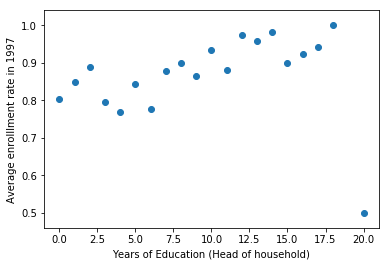

In [11]:
x = [data.hohedu.unique()]
x.sort()

list = []
for i in np.arange(21):
    temp = data.sc97[data['hohedu']==i].mean()
    list.append(temp)

del list[19]
y = list

plt.scatter(x, y)
plt.xlabel('Years of Education (Head of household)')
plt.ylabel('Average enrolllment rate in 1997')
plt.show()

Generally, enrollment rate and parents' total education level in years are positively correlated. That is, the more education the parent has, the higher the average enrollment rate for students.

Now we can reate a histogram of village enrollment rates among poor households
in program-participating villages, before and after the program.  Specifically, for
each village, we can calculate the average rate of enrollment of poor
households in villages that participated in the program in 1997, then compute the average rate
of enrollment of poor households in program-participating villages in 1998.

In [12]:
poor_andProgram = data[np.logical_and(data.poor_==1, data.progresa_==1)]

#before program
before = poor_andProgram[poor_andProgram.year==97]
before_means = before.groupby(['village']).mean()
before_enrollment = before_means['sc97']
before_total_mean = before_enrollment.mean()

#after program
after = poor_andProgram[poor_andProgram.year==98]
after_means = after.groupby(['village']).mean()
after_enrollment = after_means['sc']
after_total_mean = after_enrollment.mean()

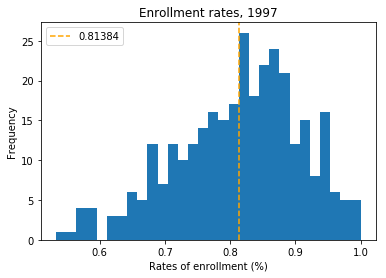

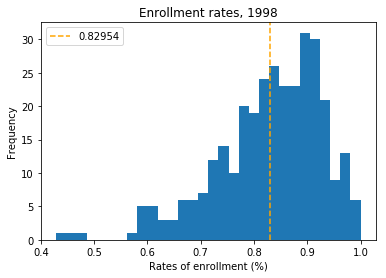

In [13]:
#histogram for before data
plt.hist(before_enrollment.values, histtype='stepfilled', bins=30)
plt.axvline(x=before_total_mean, color='orange', linestyle='--', label=str(round(before_total_mean, 5)))

plt.title('Enrollment rates, 1997')
plt.xlabel('Rates of enrollment (%)')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

#histogram for after data
plt.hist(after_enrollment.values, histtype='stepfilled', bins=30)
plt.axvline(x=after_total_mean, color='orange', linestyle='--', label=str(round(after_total_mean, 5)))

plt.title('Enrollment rates, 1998')
plt.xlabel('Rates of enrollment (%)')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

In [14]:
#is before and after diff of means statistically significant?
before_stdev = before_enrollment.std()
n1 = len(before_enrollment.index)

after_stdev = after_enrollment.std()
n2 = len(after_enrollment.index)

In [15]:
std_error3 = before_stdev**2 / n1
std_error4 = after_stdev**2 / n2
total_std_error1 = np.sqrt(std_error3 + std_error4)

t_stat2 = (after_total_mean - before_total_mean) / total_std_error1

#df for two samples is (n1 + n2) - 2
degrees_freedom2 = n1 + n2 - 2

pValue1 = 1 - stats.t.cdf(t_stat2, df=degrees_freedom2)
p3 = pValue1.round(7)
print('p-value for before and after difference of means: ', p3)

p-value for before and after difference of means:  0.0221244


There is a slight difference between the means in the before and after case for the rates of enrollment in poor villages where the program was applied. Perhaps more noticeable is the shift towards the right in the after case, where more data is towards higher enrollment rates (thus the shift in the mean). <br>

After doing doing a significance test, we find a p-value of ~0.022, which means that the shift in the means would be highly unlikely without participating in the program. Therefore, I think this difference in the means is statistically significant.

## Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on
the social and economic outcomes of individuals in Mexico. We will
focus on the impact of the program on the poor, since only the poor were eligible to receive the PROGRESA assistance.

### Cross-Sectional Estimator: T-test, ''simple differences''

We can begin by estimating the impact of Progresa using "simple differences."
Restricting ourselves to data from 1998 (after program), we can calculate
the average enrollment rate among **poor** households in the program-participating
villages and the average enrollment rate among **poor** households in
the control villages. Then we can use a t-test to determine if this difference is
statistically significant.

In [16]:
#program group
poor_Program = data[np.logical_and(data.poor_==1, data.progresa_==1)]
after_progresa = poor_Program[poor_Program.year==98]

#non-program group
poor_notProgram = data[np.logical_and(data.poor_==1, data.progresa_==0)]
after_control = poor_notProgram[poor_notProgram.year==98]

In [17]:
after_means_program = after_progresa.groupby(['village']).mean()
after_program_enrollment = after_means_program['sc']
after_program_mean = after_program_enrollment.mean()

after_means_control = after_control.groupby(['village']).mean()
after_control_enrollment = after_means_control['sc']
after_control_mean = after_control_enrollment.mean()

In [18]:
#t test
ap_stdev = after_program_enrollment.std()
_n1 = len(after_program_enrollment.index)

ac_stdev = after_control_enrollment.std()
_n2 = len(after_control_enrollment.index)

In [19]:
standard_error = ap_stdev**2 / _n1
standard_error2 = ac_stdev**2 / _n2
total_standard_error = np.sqrt(standard_error + standard_error2)

t_statistic = (after_program_mean - after_control_mean) / total_standard_error
print('test statistic: ', t_statistic, '\n')

#df for two samples is (n1 + n2) - 2
d_free = _n1 + _n2 - 2

p_value = 1 - stats.t.cdf(t_statistic, df=d_free)
p = p_value.round(7)
print('p-value for before and after difference of means: ', p)

test statistic:  2.528676111365301 

p-value for before and after difference of means:  0.005877


The p-value is extremely low. This means that we can reject the null hypothesis that there is no difference between the means of enrollment rates between villages that did and didn't participate in the program. Therefore, we can say that based on our statistically significant p-value, the program seemed to work in raising enrollment rates after the program analysis during 1998.

### Cross-Sectional Estimator: Regression

We can estimate the effects of Progresa on enrollment using a regression
model, by regressing the 1998 enrollment rates **of the poor** on
whether or not they participated in the program.

In [20]:
#simple regression
m = smf.ols(formula = "sc ~ progresa_", data=data[np.logical_and(data.year==98, data.poor_==1)]).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           6.64e-17
Time:                        20:42:05   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8076      0.004    220.676      0.0

Based on this model, the Progresa program increased the likelihood of a child enrolling by ~3.8%. The intercept can be interpreted as the base enrollment given no access to the program, and the coefficient of enrollment rates is 0.0388, corresponding to the indicated increase. <br>

This regression estimate is larger than my t-test estimate from the T-test, "simple differences" section. This actually means that there is even more reason to reject the null hypothesis. My t-statistic is farther from 0, meaning that it is more likely that there *is* a statistically significant difference between the means. And futhermore, my p-values in the regression model are smaller, which backs up this claim.<br>

Based on this regression model, I believe that we can reject the null hypothesis that the program effects are zero because of the incredibly low p-values.<br>

The counterfacutal assumption underlying this regression is that a child cannot be both in a program-participating group and a control group. That is, for each child, they can either be experiencing the Progresa program or not experiencing it, but not both.

### Multiple Regression

Now we can re-run the above regression estimated but this time include a set of
relevant control variables (for instance, age, distance to a secondary
school, gender, education of household head, welfare index,
indigenous, etc.).

In [21]:
#multiple regression
m = smf.ols(formula = "sc ~ progresa_ + age + hohedu + hohsex + hohwag + dist_sec + min_dist + indig + sex + welfare_index", 
            data=data[np.logical_and(data.year==98, data.poor_==1)]).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     1015.
Date:                Sat, 29 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:42:05   Log-Likelihood:                -7556.2
No. Observations:               27264   AIC:                         1.513e+04
Df Residuals:                   27253   BIC:                         1.522e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4416      0.017     86.730

When including other factors into the regression equation, the base level for enrollment without the program goes up.<br>

It was also noteworthy that head of household wage and welfare index had nearly zero effect on enrollment rate. This could be because we are looking at poor subsets of the population, so perhaps the wage gaps given that different families were considered "poor" weren't that high.<br>

The factors that seemed to influence enrollment rates (other than poor_==1 and progresa_==1, of course), are gender (positive for males), and whether the family had indigenous roots. My hypothesis is that poor indigenous families may have had a disproportionate lack of funds before the program started, so Progresa was more likely to positively impact those families. However, further evidence is needed to support that claim. <br>

And in the opposite direction, it seemed that that age seemed to negatively affect how well the program worked. This could be because of the way the program was incentivized: promising to pay for education from the 2nd or 3rd grade through 8th or 9th grade (accepting that this might change due to political changes as the presidential election was coming up), perhaps families with children just starting school were more likely to join and use the program. This could also mean that children who had already missed a certain amount of schooling (or already completed a certain amount) were likely to retain the same enrollment habits as before. Or that there was something else entirely going on outside of the program that made the changes. These correspond to a set of three stories we could tell ourselves about causality.<br>

Standard error seems to decrease for the intercept, while that of 'progresa_ stays the same.

### Difference-in-Difference

Instead of computing the difference in 1998 enrollment rates across villages, we could compute the effect of the program using a differences-in-differences approach.

We can construct our analysis by using:

a) the difference (between 1997 and 1998) in enrollment rates among poor households in program-participating villages

b) the difference (between 1997 and 1998) in enrollment rates among poor households in control villages.

c) The difference between these two differences is our estimate.

In [22]:
#before/after, with program
#eap = enrollment after program
#ebp = enrollment before program
eap = data.groupby([data.poor_==1,data.year==98, data.progresa_==1])['sc'].mean()
ebp = data.groupby([data.poor_==1,data.year==97, data.progresa_==1])['sc'].mean()
program = eap - ebp

#before/after, control
eac = data.groupby([data.poor_==1,data.year==98, data.progresa_==0])['sc'].mean()
ebc = data.groupby([data.poor_==1,data.year==97, data.progresa_==0])['sc'].mean()
control = eac - ebc

#diff-in-diff
diff_diff = program - control

print(diff_diff)

poor_  year   progresa_
False  False  False        0.000034
              True        -0.000034
       True   False       -0.000034
              True         0.000034
True   False  False        0.031331
              True        -0.031331
       True   False       -0.031331
              True         0.031331
Name: sc, dtype: float64


Looking at the table and reading off poor_ = True, year = True, progresa_ = True, we see that this simple diff-in-diff estimator has calculated a 3.1% difference in enrollment rates for poor, program-participating villages accounting for the year before and after the program started. Enrollment rates when accounting for the Progresa program seem to be hovering around 3%, although this value is a bit less than when we calculated the diff-in-diff estimate comparing 'sc' and 'progresa_' alone.<br>

I think that the counterfacutal assumption underlying this estimate is that a child cannot be both in a program-participating group and a control group. We cannot observe a child have bother undergone the Progresa program and not undergone it.

### Difference-in-Difference (regression)

What about using regression to estime the average program effects?

In [23]:
#dff-in-diff, regression
data['nine_eight'] = np.where(data.year == 98, 1, 0)

#diff-in-diff effect: progresa_ * nine_eight
# this is: program + time + program*time
m = smf.ols(formula = "sc ~ poor_ + progresa_ + nine_eight + progresa_ * nine_eight + indig", 
            data=data).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     77.46
Date:                Sat, 29 Jun 2019   Prob (F-statistic):           2.77e-81
Time:                        20:42:05   Log-Likelihood:                -31560.
No. Observations:               68564   AIC:                         6.313e+04
Df Residuals:                   68558   BIC:                         6.319e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.7703 

I think that the effects of the Progresa program were overall positive. As we can see, the coefficients of the poor_ and progresa_ terms are non-trivial (together accounting for more than a 3% increase in enrollment rates), and the standard errors as well as the p-values are very low. This means that we can be sure the effects are due to the program, and not random chance. The time column, nine_eight, has a negative effect on enrollment rates, but the p-value is high. Enough so that we cannot be sure that it is anywhere close to statistically significant. This can be translated to being unsure whether the enrollment rates increased or decreased due to the program or time alone. When we look at the progresa_:nine_eight coefficient (program accounting for time), we see that it has a relatively large positive effect (~2.5%) on enrollment rates, and that it has a low standard error and a p-value of 0.015. This is means we can call the program account for time's coefficient as statistically significant.<br>

The value I obtained for progresa_:nine_eight, my diff-in-diff estimator, is very close to that of the value I obtained doing the simple difference calculation in part 2.1.<br>

The rate of enrollment due to the Progresa program alone is smalller than it was in part 2.4. This is most likely because we are now taking into account things like whether a family has indigenous roots or not. However, if we add the poor_, nine_eight, and progresa_ coeffiecients together, the value is almost exactly that of what we got in part 2.4<br>

The counterfactual assumption underlying this regression is that one cannot be both both (poor, participate in the program, and indigenous) and (not poor, be in the control group, and not indigenous).

### Summary

I do believe that the Progresa program had a causal impact on the enrollment rates of poor households in Mexico. We analyzed the baseline demographic characteristics and found little to no differences between program-participating and control villages. After comparing the program-participating and control groups enrollment rates, the program versus time enrollment rates, and control and program-participating villages both against time, again and again we have seen that enrollment rates are consistently higher due to the program. This even holds after taking into account many important control variables. <br>

There were some noticeable exceptions when the Progresa program did not help, however. Principally, it seems that as age increased, the enrollment rates decreased. I have speculated about that above. It could be due to as a child learns more sellable skills as they age, the investment into schooling even given Progresa does not return enough for the family to have the child stop working and omit their income from the family pool. It could be for a multitude of reasons, but I think that without further analysis every explanation remains speculative. <br>

I would say that the data does point to the program being most effective when the child is young, the family is indigenous, and when the distance to a secondary school isn't too far away. I think this is a combination of factors resulting in a maximum return for indigenous families investing in their child's education. This might perhaps point to the fact that poor, indigenous families have less opportunites to send their child to school than their counterparts.<br>

One interesting thing to note: I saw a positive increase in enrollment rates for males after accounting for program and time, even though the author found the opposite to be true. And with a low p-value, I think this result is statistically significant, although the standard error associated to this result is rather high.